In [2]:
from bluesky import RunEngine
from ophyd import Device, Signal
from ophyd import Component as Cpt
from ophyd.sim import det, motor1, motor2, noisy_det, SynGauss, SynAxis, SynSignal,EnumSignal
from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky.plans import scan, rel_scan, list_scan, grid_scan
from bluesky.plan_stubs import mv
from databroker import Broker

## RunEngine

In [3]:
RE = RunEngine({})
bec = BestEffortCallback()
RE.subscribe(bec)
db = Broker.named('temp')
RE.subscribe(db.v1.insert)

1

## Simulated Device

### For now, just ignore the implementation of this SynDevice.
#### But it just implements a "Gaussian Integrator" for simulating a Knife Edge scan

In [7]:
import numpy as np #Hide this import here just for now
class SynKnifeDetector(Device):

    def _compute(self):
        m = self._motor.read()[self._motor_field]["value"]
        
        # we need to do this one at a time because
        #   - self.read() may be screwed with by the user
        #   - self.get() would cause infinite recursion
        Imax = self.Imax.get()
        center = self.center.get()
        sigma = self.sigma.get()
        noise = self.noise.get()
        noise_multiplier = self.noise_multiplier.get()
        
        x = np.arange(-20, 20, 0.1)
        gauss = [-Imax * np.exp(-((x_val - center) ** 2) / (2 * sigma**2)) for x_val in x]
        trapz = [np.trapezoid(gauss[:-i]) for i in range(x.shape[0])][::-1]
        
        agr_for_calculation = np.argmin(np.abs(x - m))
        v = trapz[agr_for_calculation]
        
        return v

    val = Cpt(SynSignal, kind="hinted")
    Imax = Cpt(Signal, value=10, kind="config")
    center = Cpt(Signal, value=0, kind="config")
    sigma = Cpt(Signal, value=1, kind="config")
    noise = Cpt(
        EnumSignal,
        value="none",
        kind="config",
        enum_strings=("none", "poisson", "uniform"),
    )
    noise_multiplier = Cpt(Signal, value=1, kind="config")

    def __init__(
        self, name, motor, motor_field, center, Imax, *, random_state=None, **kwargs
    ):
        set_later = {}
        for k in ("sigma", "noise", "noise_multiplier"):
            v = kwargs.pop(k, None)
            if v is not None:
                set_later[k] = v
        super().__init__(name=name, **kwargs)
        self._motor = motor
        self._motor_field = motor_field
        self.center.put(center)
        self.Imax.put(Imax)

        self.random_state = random_state or np.random
        self.val.name = self.name
        self.val.sim_set_func(self._compute)
        for k, v in set_later.items():
            getattr(self, k).put(v)

        self.trigger()

    def subscribe(self, *args, **kwargs):
        return self.val.subscribe(*args, **kwargs)

    def clear_sub(self, cb, event_type=None):
        return self.val.clear_sub(cb, event_type=event_type)

    def unsubscribe(self, cid):
        return self.val.unsubscribe(cid)

    def unsubscribe_all(self):
        return self.val.unsubscribe_all()

    def trigger(self, *args, **kwargs):
        return self.val.trigger(*args, **kwargs)

    @property
    def precision(self):
        return self.val.precision

    @precision.setter
    def precision(self, v):
        self.val.precision = v

    @property
    def exposure_time(self):
        return self.val.exposure_time

    @exposure_time.setter
    def exposure_time(self, v):
        self.val.exposure_time = v


In [8]:
motor = SynAxis(name='motor1')
detector = SynKnifeDetector('Knife', motor, 'motor1', center=2, Imax=9, sigma=1)



Transient Scan ID: 1     Time: 2024-08-26 17:10:47
Persistent Unique Scan ID: '28237c8d-7ded-4612-8b81-faad5a9ab950'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |     motor1 |      Knife |
+-----------+------------+------------+------------+
|         1 | 17:10:47.3 |    -10.000 |     -0.000 |
|         2 | 17:10:47.3 |     -9.800 |     -0.000 |
|         3 | 17:10:47.4 |     -9.600 |     -0.000 |
|         4 | 17:10:47.4 |     -9.400 |     -0.000 |
|         5 | 17:10:47.4 |     -9.200 |     -0.000 |
|         6 | 17:10:47.5 |     -9.000 |     -0.000 |
|         7 | 17:10:47.5 |     -8.800 |     -0.000 |
|         8 | 17:10:47.5 |     -8.600 |     -0.000 |
|         9 | 17:10:47.6 |     -8.400 |     -0.000 |
|        10 | 17:10:47.6 |     -8.200 |     -0.000 |
|        11 | 17:10:47.6 |     -8.000 |     -0.000 |
|        12 | 17:10:47.7 |     -7.800 |     -0.000 |
|        13 | 17:10:47.7 |     -7.600 |     -0.000 |
|        14

('28237c8d-7ded-4612-8b81-faad5a9ab950',)

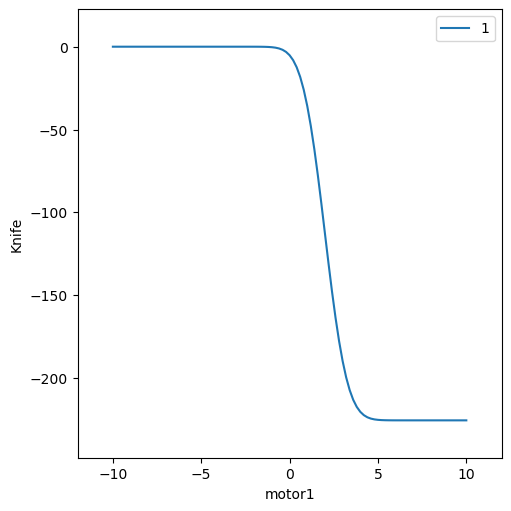

In [9]:
RE(scan([detector], motor, -10, 10, 101))

In [ ]:
data = db[-1].table() #Should we use databroker now?